## Librerias

In [1]:
import pandas as pd
import lightgbm as lgb
import optuna
import numpy as np
import shap
import matplotlib.pyplot as plt
import joblib

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, f1_score,classification_report
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import precision_recall_fscore_support
from tqdm import tqdm
from imblearn.under_sampling import RandomUnderSampler


scaler = RobustScaler()
le = LabelEncoder()


## Lectura del Archivo

In [2]:
fileName= "data_set_integrado_modelo_final_futuro_binario.csv"
path="../franco/"

# Read the CSV file
df = pd.read_csv(path + fileName)
df = df.sort_values(by=['fecha'])


Distribución de clases (%):
label_t_plus_1
NO_SUBE    54.073565
SUBE       45.926435
Name: proportion, dtype: float64


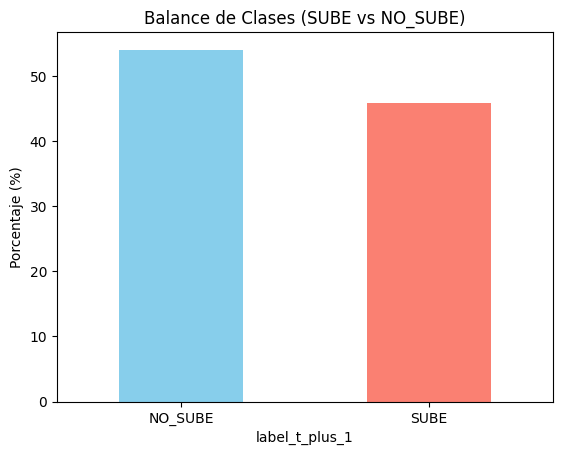

In [3]:
#Analisis basico de distribucion


# Contar muestras por clase
class_distribution = df['label_t_plus_1'].value_counts(normalize=True) * 100
print("Distribución de clases (%):")
print(class_distribution)

# Gráfico de barras
class_distribution.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title("Balance de Clases (SUBE vs NO_SUBE)")
plt.ylabel("Porcentaje (%)")
plt.xticks(rotation=0)
plt.show()

In [4]:
# Visualizacion  balance por empresa
balance_por_empresa[['%_SUBE', '%_NO_SUBE']].plot(
    kind='bar', 
    stacked=True, 
    color=['#4CAF50', '#F44336'],  # Verde: SUBE, Rojo: NO_SUBE
    figsize=(12, 6)
)
plt.axhline(y=50, color='gray', linestyle='--', label='Balance ideal (50/50)')
plt.title('Balance de Clases por Empresa')
plt.ylabel('Proporción (%)')
plt.legend(title='Clase')
plt.show()

NameError: name 'balance_por_empresa' is not defined

Codifico el target y empresas

In [5]:
# Codificar target
df['target'] = df['label_t_plus_1'].apply(lambda x: 1 if x == 'SUBE' else 0)

Crear características temporales específicas por empresa

In [7]:
# Features de rolling por empresa
for empresa in tqdm(df['nombre'].unique(), desc="Calculando rolling features"):
    mask = df['nombre'] == empresa
    df.loc[mask, 'volumen_media_7d'] = df.loc[mask, 'volumen_operado'].rolling(7).mean()
    df.loc[mask, 'retorno_5d'] = df.loc[mask, 'precio_cierre'].pct_change(5)
    df.loc[mask, 'sentimiento_pos_media_5d'] = df.loc[mask, 'suma_score_sentimiento_positivas'].rolling(5).mean()


Calculando rolling features: 100%|██████████| 9/9 [00:00<00:00, 76.63it/s]


In [8]:
# Interacciones clave
df['sentimiento_volatilidad'] = df['suma_score_sentimiento_positivas'] * df['precio_cierre_std_5d']
df['volumen_sentimiento'] = df['volumen_operado'] * df['suma_score_sentimiento_positivas']

#  DIVISIÓN TEMPORAL ESTRATIFICADA POR EMPRESA

In [9]:
def temporal_train_test_split(df, train_size=0.8):
    """División temporal manteniendo proporción de empresas en train/test"""
    fechas_unicas = df['fecha'].sort_values().unique()
    split_idx = int(len(fechas_unicas) * train_size)
    train_dates = fechas_unicas[:split_idx]
    test_dates = fechas_unicas[split_idx:]
    
    train_mask = df['fecha'].isin(train_dates)
    test_mask = df['fecha'].isin(test_dates)
    
    return train_mask, test_mask

In [179]:
X_test

,id_cotizacion,id_empresa,fecha,precio_apertura,precio_cierre,precio_max,precio_min,volumen_operado,variacion_porcentaje,nombre,...,total_noticias_negativas_std_5d,ratio_sent_positivo_negativo,diff_score_sentimiento,label_t_plus_1,target,volumen_media_7d,retorno_5d,sentimiento_pos_media_5d,sentimiento_volatilidad,volumen_sentimiento
1228,2822,13,2025-01-21,15.65,15.75,15.90,15.50,159903.66,0.000000,MELID,...,22.241852,-0.962389,77.3342,NO_SUBE,0,230409.561429,0.039604,43.36208,1.038646,6.064506e+06
904,2268,12,2025-01-21,12.90,12.75,12.90,12.70,531378.19,-0.390625,KOD,...,22.241852,-0.962389,77.3342,NO_SUBE,0,332880.121429,0.003937,43.36208,1.896300,2.015305e+07
1876,3930,15,2025-01-21,5.93,6.02,6.03,5.85,114388.03,0.668896,NVDAD,...,22.241852,-0.962389,77.3342,SUBE,1,213155.901429,0.067376,43.36208,3.928592,4.338280e+06
259,1160,10,2025-01-21,11.75,11.30,11.75,11.15,293465.06,-4.237288,AAPLD,...,22.241852,-0.962389,77.3342,SUBE,1,145337.907143,-0.054393,43.36208,12.142244,1.112996e+07
2520,5037,17,2025-01-21,19.35,19.55,19.60,19.00,437617.41,1.822917,VISTD,...,22.241852,-0.962389,77.3342,SUBE,1,474412.171429,-0.015113,43.36208,16.057082,1.659708e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1292,5750,13,2025-04-29,18.85,18.85,18.85,18.50,75948.05,NaN,MELID,...,9.884331,-1.032572,90.7720,NO_SUBE,0,56496.792857,0.047222,42.97250,13.601469,3.502215e+06
968,5754,12,2025-04-29,14.55,14.55,14.65,14.35,18251.60,NaN,KOD,...,9.884331,-1.032572,90.7720,NO_SUBE,0,66207.984286,-0.030000,42.97250,9.863289,8.416415e+05
1940,5752,15,2025-04-29,4.64,4.60,4.65,4.56,17817.76,NaN,NVDAD,...,9.884331,-1.032572,90.7720,NO_SUBE,0,86046.322857,0.090047,42.97250,3.366587,8.216357e+05
1616,5753,14,2025-04-29,13.20,13.40,13.40,13.15,10300.35,NaN,MSFTD,...,9.884331,-1.032572,90.7720,NO_SUBE,0,25238.857143,0.080645,42.97250,8.408568,4.749831e+05


In [11]:
train_mask, test_mask = temporal_train_test_split(df)
X_train, X_test = df.loc[train_mask], df.loc[test_mask]
y_train, y_test = df.loc[train_mask, 'target'], df.loc[test_mask, 'target']

# Verificar distribución de empresas
print("\nDistribución de empresas en test:")
print(X_test['nombre'].value_counts())


Distribución de empresas en test:
nombre
MELID    65
KOD      65
NVDAD    65
AAPLD    65
VISTD    65
MSFTD    65
XOMD     65
DESPD    62
TEND     61
Name: count, dtype: int64


# BALANCEO DE CLASES Y PREPROCESAMIENTO

In [12]:
# Balancear solo el conjunto de entrenamiento
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

# Preprocesamiento
numeric_features = ['precio_cierre', 'volumen_operado', 'suma_score_sentimiento_positivas', 
                   'volumen_media_7d', 'retorno_5d', 'sentimiento_volatilidad']
categorical_features = ['nombre']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

X_train_processed = preprocessor.fit_transform(X_resampled)
X_test_processed = preprocessor.transform(X_test)



In [13]:
# Obtener nombres de features
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['nombre'])
all_features = list(cat_features) + numeric_features

# Optimizacion con OPTUNA

In [19]:
def objective(trial):
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart']),
        'num_leaves': trial.suggest_int('num_leaves', 20, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0, 5),
        'lambda_l2': trial.suggest_float('lambda_l2', 0, 5),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 50),
        'verbose': -1,
        'class_weight': {0: 1, 1: trial.suggest_float('class_weight', 1.5, 3.0)}  # Peso ajustable para "SUBE"
    }
    
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_processed, y_resampled,
              eval_set=[(X_test_processed, y_test)],
              callbacks=[
                        lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
                        lgb.log_evaluation(period=10)             # imprime log cada 10 iter
                        ]
              )

    
    y_pred = model.predict(X_test_processed)
    return f1_score(y_test, y_pred)  # Optimizamos para maximizar F1-Score

In [20]:
# Ejecutar optimización
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30, show_progress_bar=True)

[I 2025-05-17 08:03:59,719] A new study created in memory with name: no-name-d140c59e-2e21-446c-a6ba-ed64b634cd1d


  0%|          | 0/30 [00:00<?, ?it/s]

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.947733
[20]	valid_0's binary_logloss: 0.945717
[30]	valid_0's binary_logloss: 0.943609
[40]	valid_0's binary_logloss: 0.94204
[50]	valid_0's binary_logloss: 0.896195


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[60]	valid_0's binary_logloss: 0.856102
[70]	valid_0's binary_logloss: 0.828075
[80]	valid_0's binary_logloss: 0.832078
[90]	valid_0's binary_logloss: 0.833827
[100]	valid_0's binary_logloss: 0.811455
[I 2025-05-17 08:04:00,566] Trial 0 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'learning_rate': 0.01047009237982434, 'feature_fraction': 0.933315950477811, 'bagging_fraction': 0.8714205778352543, 'bagging_freq': 1, 'lambda_l1': 4.9420290265103075, 'lambda_l2': 3.7039734675075255, 'min_data_in_leaf': 13, 'class_weight': 2.9837277240219815}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.813247
[20]	valid_0's binary_logloss: 0.821179
[30]	valid_0's binary_logloss: 0.829076


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[40]	valid_0's binary_logloss: 0.814113
[50]	valid_0's binary_logloss: 0.824393
[60]	valid_0's binary_logloss: 0.822723
[70]	valid_0's binary_logloss: 0.826192
[80]	valid_0's binary_logloss: 0.832028
[90]	valid_0's binary_logloss: 0.83405
Early stopping, best iteration is:
[41]	valid_0's binary_logloss: 0.812033
[I 2025-05-17 08:04:00,736] Trial 1 finished with value: 0.5493910690121786 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 51, 'learning_rate': 0.08264217285266302, 'feature_fraction': 0.7907241037303078, 'bagging_fraction': 0.7010523330492269, 'bagging_freq': 3, 'lambda_l1': 0.5114225366325209, 'lambda_l2': 0.802537961542209, 'min_data_in_leaf': 43, 'class_weight': 2.129143417314727}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.909172
[20]	valid_0's binary_logloss: 0.878054
[30]	valid_0's binary_logloss: 0.883239
[40]	valid_0's binary_logloss: 0.893368
[50]	valid_0's bina

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[70]	valid_0's binary_logloss: 0.89402
Early stopping, best iteration is:
[24]	valid_0's binary_logloss: 0.876008
[I 2025-05-17 08:04:00,879] Trial 2 finished with value: 0.5671641791044776 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 97, 'learning_rate': 0.13483201061833758, 'feature_fraction': 0.994920499724885, 'bagging_fraction': 0.826812315233228, 'bagging_freq': 9, 'lambda_l1': 4.763546604810831, 'lambda_l2': 0.9868501844675631, 'min_data_in_leaf': 48, 'class_weight': 2.6244952372024155}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.781225
[20]	valid_0's binary_logloss: 0.779383
[30]	valid_0's binary_logloss: 0.780328
[40]	valid_0's binary_logloss: 0.777753
[50]	valid_0's binary_logloss: 0.775489
[60]	valid_0's binary_logloss: 0.77574
[70]	valid_0's binary_logloss: 0.777006
[80]	valid_0's binary_logloss: 0.776153


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.772044
[100]	valid_0's binary_logloss: 0.774358
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.771659
[I 2025-05-17 08:04:01,129] Trial 3 finished with value: 0.5351351351351351 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 52, 'learning_rate': 0.03231869559772719, 'feature_fraction': 0.7611751999976856, 'bagging_fraction': 0.8739272541500204, 'bagging_freq': 4, 'lambda_l1': 0.006237362589583406, 'lambda_l2': 2.4147986191671182, 'min_data_in_leaf': 46, 'class_weight': 1.7279343748336378}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.860524
[20]	valid_0's binary_logloss: 0.906312
[30]	valid_0's binary_logloss: 0.8834
[40]	valid_0's binary_logloss: 0.906802
[50]	valid_0's binary_logloss: 0.912997
Early stopping, best iteration is:
[8]	valid_0's binary_logloss: 0.859391


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[I 2025-05-17 08:04:01,290] Trial 4 finished with value: 0.5653266331658291 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'learning_rate': 0.2703741818153366, 'feature_fraction': 0.8868329154400758, 'bagging_fraction': 0.9673945974044852, 'bagging_freq': 4, 'lambda_l1': 0.06061237688196608, 'lambda_l2': 2.263041425524554, 'min_data_in_leaf': 43, 'class_weight': 2.671700139209471}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.887971
[20]	valid_0's binary_logloss: 0.874608
[30]	valid_0's binary_logloss: 0.873649
[40]	valid_0's binary_logloss: 0.874405
[50]	valid_0's binary_logloss: 0.869411


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[60]	valid_0's binary_logloss: 0.868573
[70]	valid_0's binary_logloss: 0.866136
[80]	valid_0's binary_logloss: 0.861884
[90]	valid_0's binary_logloss: 0.860603
[100]	valid_0's binary_logloss: 0.861729
Did not meet early stopping. Best iteration is:
[89]	valid_0's binary_logloss: 0.859724
[I 2025-05-17 08:04:01,613] Trial 5 finished with value: 0.5635910224438903 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 73, 'learning_rate': 0.02234958274048572, 'feature_fraction': 0.8405414749922893, 'bagging_fraction': 0.7530624756094368, 'bagging_freq': 6, 'lambda_l1': 1.0800401368470458, 'lambda_l2': 1.7158005946711774, 'min_data_in_leaf': 18, 'class_weight': 2.5705870723779785}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.887375
[20]	valid_0's binary_logloss: 0.880987
[30]	valid_0's binary_logloss: 0.875108
[40]	valid_0's binary_logloss: 0.868595
[50]	valid_0's binary_logloss: 0.863376
[6

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's binary_logloss: 0.853417
Did not meet early stopping. Best iteration is:
[82]	valid_0's binary_logloss: 0.852939
[I 2025-05-17 08:04:01,961] Trial 6 finished with value: 0.5627376425855514 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 75, 'learning_rate': 0.026940695837446398, 'feature_fraction': 0.7299113809445066, 'bagging_fraction': 0.7713507749727501, 'bagging_freq': 1, 'lambda_l1': 0.29541180847251325, 'lambda_l2': 1.903319821522222, 'min_data_in_leaf': 16, 'class_weight': 2.559425560581718}. Best is trial 0 with value: 0.5675340768277571.
Training until validation scores don't improve for 50 rounds
[10]	valid_0's binary_logloss: 0.883162
[20]	valid_0's binary_logloss: 0.878566
[30]	valid_0's binary_logloss: 0.883332
[40]	valid_0's binary_logloss: 0.875124


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[50]	valid_0's binary_logloss: 0.87449
[60]	valid_0's binary_logloss: 0.872716
[70]	valid_0's binary_logloss: 0.86826
[80]	valid_0's binary_logloss: 0.869558
[90]	valid_0's binary_logloss: 0.865965
[100]	valid_0's binary_logloss: 0.864421
Did not meet early stopping. Best iteration is:
[100]	valid_0's binary_logloss: 0.864421
[I 2025-05-17 08:04:02,328] Trial 7 finished with value: 0.5642946317103621 and parameters: {'boosting_type': 'gbdt', 'num_leaves': 63, 'learning_rate': 0.02597044032005364, 'feature_fraction': 0.9368897352734462, 'bagging_fraction': 0.7621511168809206, 'bagging_freq': 3, 'lambda_l1': 2.0759781400637554, 'lambda_l2': 3.5923088342760483, 'min_data_in_leaf': 10, 'class_weight': 2.481877693408854}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.930683
[20]	valid_0's binary_logloss: 0.921874
[30]	valid_0's binary_logloss: 0.916355
[40]	valid_0's binary_logloss: 0.90571
[50]	valid_0's binary_logloss: 0.875506
[60]	valid_0's binary_logloss: 0.84111
[70]	valid_0's binary_logloss: 0.831012
[80]	valid_0's binary_logloss: 0.853317


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.856208
[100]	valid_0's binary_logloss: 0.845571
[I 2025-05-17 08:04:02,657] Trial 8 finished with value: 0.5639097744360902 and parameters: {'boosting_type': 'dart', 'num_leaves': 33, 'learning_rate': 0.0612015073344307, 'feature_fraction': 0.9142743642689997, 'bagging_fraction': 0.9140232555911408, 'bagging_freq': 5, 'lambda_l1': 0.712372041243467, 'lambda_l2': 1.7785657471586553, 'min_data_in_leaf': 19, 'class_weight': 2.9677717625015267}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.802609
[20]	valid_0's binary_logloss: 0.790285
[30]	valid_0's binary_logloss: 0.7937
[40]	valid_0's binary_logloss: 0.798132
[50]	valid_0's binary_logloss: 0.784873
[60]	valid_0's binary_logloss: 0.7631
[70]	valid_0's binary_logloss: 0.762633


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[80]	valid_0's binary_logloss: 0.777962
[90]	valid_0's binary_logloss: 0.778759
[100]	valid_0's binary_logloss: 0.779356
[I 2025-05-17 08:04:02,922] Trial 9 finished with value: 0.5483870967741935 and parameters: {'boosting_type': 'dart', 'num_leaves': 34, 'learning_rate': 0.09505226971505551, 'feature_fraction': 0.7157283679888587, 'bagging_fraction': 0.7592415729517681, 'bagging_freq': 5, 'lambda_l1': 1.1725807988584391, 'lambda_l2': 2.6200193085803396, 'min_data_in_leaf': 38, 'class_weight': 1.945617844917624}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.948402
[20]	valid_0's binary_logloss: 0.946354
[30]	valid_0's binary_logloss: 0.947459
[40]	valid_0's binary_logloss: 0.947637
[50]	valid_0's binary_logloss: 0.90199
[60]	valid_0's binary_logloss: 0.861199
[70]	valid_0's binary_logloss: 0.876762
[80]	valid_0's binary_logloss: 0.888213
[90]	valid_0's binary_logloss: 0.903471
[100]	valid_0's binary_logloss: 0.986494


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[I 2025-05-17 08:04:03,268] Trial 10 finished with value: 0.0 and parameters: {'boosting_type': 'dart', 'num_leaves': 94, 'learning_rate': 0.011792645344553274, 'feature_fraction': 0.9939932740756438, 'bagging_fraction': 0.9716075355188554, 'bagging_freq': 1, 'lambda_l1': 4.960092175303594, 'lambda_l2': 4.924838283858767, 'min_data_in_leaf': 28, 'class_weight': 2.984250118358204}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.906439
[20]	valid_0's binary_logloss: 0.880734
[30]	valid_0's binary_logloss: 0.901879
[40]	valid_0's binary_logloss: 0.900159


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[50]	valid_0's binary_logloss: 0.90058
[60]	valid_0's binary_logloss: 1.04698
[70]	valid_0's binary_logloss: 1.23605
[80]	valid_0's binary_logloss: 1.23543
[90]	valid_0's binary_logloss: 1.24704
[100]	valid_0's binary_logloss: 1.2599
[I 2025-05-17 08:04:03,614] Trial 11 finished with value: 0.44881889763779526 and parameters: {'boosting_type': 'dart', 'num_leaves': 98, 'learning_rate': 0.1640318022000675, 'feature_fraction': 0.999700685490476, 'bagging_fraction': 0.8464954171923799, 'bagging_freq': 10, 'lambda_l1': 4.870905488009516, 'lambda_l2': 0.5112969555476243, 'min_data_in_leaf': 31, 'class_weight': 2.808565890510738}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[10]	valid_0's binary_logloss: 0.868281
[20]	valid_0's binary_logloss: 0.866257
[30]	valid_0's binary_logloss: 0.866493
[40]	valid_0's binary_logloss: 0.867048
[50]	valid_0's binary_logloss: 0.836855
[60]	valid_0's binary_logloss: 0.810167
[70]	valid_0's binary_logloss: 0.789931
[80]	valid_0's binary_logloss: 0.792523
[90]	valid_0's binary_logloss: 0.793975
[100]	valid_0's binary_logloss: 0.77742
[I 2025-05-17 08:04:04,070] Trial 12 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'learning_rate': 0.01029744372157163, 'feature_fraction': 0.9459090240215494, 'bagging_fraction': 0.8444812671791845, 'bagging_freq': 9, 'lambda_l1': 3.782388507100084, 'lambda_l2': 3.837714144042712, 'min_data_in_leaf': 50, 'class_weight': 2.3273136098338507}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.757009
[20]	valid_0's binary_logloss: 0.7569
[30]	valid_0's binary_logloss: 0.756188
[40]	valid_0's binary_logloss: 0.757042
[50]	valid_0's binary_logloss: 0.746393
[60]	valid_0's binary_logloss: 0.737347
[70]	valid_0's binary_logloss: 0.730351
[80]	valid_0's binary_logloss: 0.731721


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.731869
[100]	valid_0's binary_logloss: 0.726004
[I 2025-05-17 08:04:04,537] Trial 13 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 85, 'learning_rate': 0.010022433320866504, 'feature_fraction': 0.948133867470539, 'bagging_fraction': 0.901516857083484, 'bagging_freq': 8, 'lambda_l1': 3.5615837245222037, 'lambda_l2': 3.7990192762268236, 'min_data_in_leaf': 26, 'class_weight': 1.5155258889008514}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.862636
[20]	valid_0's binary_logloss: 0.857474


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[30]	valid_0's binary_logloss: 0.856884
[40]	valid_0's binary_logloss: 0.857322
[50]	valid_0's binary_logloss: 0.829422
[60]	valid_0's binary_logloss: 0.803953
[70]	valid_0's binary_logloss: 0.78614
[80]	valid_0's binary_logloss: 0.790004
[90]	valid_0's binary_logloss: 0.791085
[100]	valid_0's binary_logloss: 0.776706
[I 2025-05-17 08:04:04,884] Trial 14 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 87, 'learning_rate': 0.014858482605155744, 'feature_fraction': 0.8589750438636963, 'bagging_fraction': 0.8054769359207206, 'bagging_freq': 7, 'lambda_l1': 3.8704606507736763, 'lambda_l2': 3.7145676682185282, 'min_data_in_leaf': 33, 'class_weight': 2.2925637273348167}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.859323
[20]	valid_0's binary_logloss: 0.856733
[30]	valid_0's binary_logloss: 0.852928
[40]	valid_0's binary_logloss: 0.853447
[50]	valid_0's binary_logloss: 0.824463
[60]	valid_0's binary_logloss: 0.799666
[70]	valid_0's binary_logloss: 0.783342
[80]	valid_0's binary_logloss: 0.785825
[90]	valid_0's binary_logloss: 0.78826


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's binary_logloss: 0.775468
[I 2025-05-17 08:04:05,248] Trial 15 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 83, 'learning_rate': 0.01768594413547416, 'feature_fraction': 0.9475927938228423, 'bagging_fraction': 0.9201064127537539, 'bagging_freq': 10, 'lambda_l1': 3.836762476744408, 'lambda_l2': 4.677565287577647, 'min_data_in_leaf': 37, 'class_weight': 2.2824220716370194}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.827081
[20]	valid_0's binary_logloss: 0.819754
[30]	valid_0's binary_logloss: 0.817313
[40]	valid_0's binary_logloss: 0.822764
[50]	valid_0's binary_logloss: 0.803388
[60]	valid_0's binary_logloss: 0.785584
[70]	valid_0's binary_logloss: 0.776945
[80]	valid_0's binary_logloss: 0.784004


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.787706
[100]	valid_0's binary_logloss: 0.77697
[I 2025-05-17 08:04:06,001] Trial 16 finished with value: 0.5610972568578554 and parameters: {'boosting_type': 'dart', 'num_leaves': 64, 'learning_rate': 0.04046427568347023, 'feature_fraction': 0.892902477221592, 'bagging_fraction': 0.874690634439661, 'bagging_freq': 7, 'lambda_l1': 3.214938177150054, 'lambda_l2': 3.0580099937383474, 'min_data_in_leaf': 22, 'class_weight': 2.0248919647778916}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.873543
[20]	valid_0's binary_logloss: 0.872619
[30]	valid_0's binary_logloss: 0.873737
[40]	valid_0's binary_logloss: 0.873
[50]	valid_0's binary_logloss: 0.840155
[60]	valid_0's binary_logloss: 0.812717
[70]	valid_0's binary_logloss: 0.792345
[80]	valid_0's binary_logloss: 0.79571


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.797782
[100]	valid_0's binary_logloss: 0.781386
[I 2025-05-17 08:04:06,393] Trial 17 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 70, 'learning_rate': 0.015442698825732805, 'feature_fraction': 0.8547189809514487, 'bagging_fraction': 0.8042417799256888, 'bagging_freq': 2, 'lambda_l1': 2.755436988017161, 'lambda_l2': 4.455769700155495, 'min_data_in_leaf': 37, 'class_weight': 2.389700294891615}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.92095


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[20]	valid_0's binary_logloss: 0.919867
[30]	valid_0's binary_logloss: 0.918747
[40]	valid_0's binary_logloss: 0.91788
[50]	valid_0's binary_logloss: 0.876083
[60]	valid_0's binary_logloss: 0.841098
[70]	valid_0's binary_logloss: 0.816818
[80]	valid_0's binary_logloss: 0.821104


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.822764
[100]	valid_0's binary_logloss: 0.80275
[I 2025-05-17 08:04:06,820] Trial 18 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 50, 'learning_rate': 0.0113150122817275, 'feature_fraction': 0.8090055499059021, 'bagging_fraction': 0.9440152515015358, 'bagging_freq': 8, 'lambda_l1': 4.3034816600508785, 'lambda_l2': 3.1428735287046696, 'min_data_in_leaf': 11, 'class_weight': 2.762630854749907}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.804959
[20]	valid_0's binary_logloss: 0.80311
[30]	valid_0's binary_logloss: 0.803965


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[40]	valid_0's binary_logloss: 0.805536
[50]	valid_0's binary_logloss: 0.786489
[60]	valid_0's binary_logloss: 0.772307
[70]	valid_0's binary_logloss: 0.763844
[80]	valid_0's binary_logloss: 0.769756


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.771201
[100]	valid_0's binary_logloss: 0.76691
[I 2025-05-17 08:04:07,257] Trial 19 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'learning_rate': 0.04246035402467096, 'feature_fraction': 0.9659091673814418, 'bagging_fraction': 0.8763844610331557, 'bagging_freq': 6, 'lambda_l1': 4.358739743389995, 'lambda_l2': 4.176999926136609, 'min_data_in_leaf': 50, 'class_weight': 1.8659865517452723}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.844458
[20]	valid_0's binary_logloss: 0.841065
[30]	valid_0's binary_logloss: 0.8373
[40]	valid_0's binary_logloss: 0.837113
[50]	valid_0's binary_logloss: 0.81213
[60]	valid_0's binary_logloss: 0.790077
[70]	valid_0's binary_logloss: 0.774381
[80]	valid_0's binary_logloss: 0.77631
[90]	valid_0's binary_logloss: 0.778504
[100]	valid_0's binary_logloss: 0.766649


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[I 2025-05-17 08:04:07,754] Trial 20 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 21, 'learning_rate': 0.01573655867839292, 'feature_fraction': 0.9079044076298753, 'bagging_fraction': 0.8195710684106327, 'bagging_freq': 9, 'lambda_l1': 2.1171788979570656, 'lambda_l2': 3.188870854392501, 'min_data_in_leaf': 24, 'class_weight': 2.1374733623616415}. Best is trial 0 with value: 0.5675340768277571.
[10]	valid_0's binary_logloss: 0.755163
[20]	valid_0's binary_logloss: 0.755011
[30]	valid_0's binary_logloss: 0.754722
[40]	valid_0's binary_logloss: 0.754605
[50]	valid_0's binary_logloss: 0.744675
[60]	valid_0's binary_logloss: 0.735548


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[70]	valid_0's binary_logloss: 0.728931
[80]	valid_0's binary_logloss: 0.730107
[90]	valid_0's binary_logloss: 0.730018
[100]	valid_0's binary_logloss: 0.724611
[I 2025-05-17 08:04:08,369] Trial 21 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 82, 'learning_rate': 0.010376875428217426, 'feature_fraction': 0.9566354667403355, 'bagging_fraction': 0.8950147278585853, 'bagging_freq': 8, 'lambda_l1': 3.367291846306015, 'lambda_l2': 3.976929469584433, 'min_data_in_leaf': 27, 'class_weight': 1.501823670094146}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.783392
[20]	valid_0's binary_logloss: 0.7821
[30]	valid_0's binary_logloss: 0.781474
[40]	valid_0's binary_logloss: 0.781004
[50]	valid_0's binary_logloss: 0.767145
[60]	valid_0's binary_logloss: 0.75412
[70]	valid_0's binary_logloss: 0.744299


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[80]	valid_0's binary_logloss: 0.745719
[90]	valid_0's binary_logloss: 0.746239
[100]	valid_0's binary_logloss: 0.737521
[I 2025-05-17 08:04:08,891] Trial 22 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 79, 'learning_rate': 0.010343725018902801, 'feature_fraction': 0.9292350147458328, 'bagging_fraction': 0.8470207252824627, 'bagging_freq': 8, 'lambda_l1': 3.5582836040907506, 'lambda_l2': 3.697694145789875, 'min_data_in_leaf': 15, 'class_weight': 1.7044966869993612}. Best is trial 0 with value: 0.5675340768277571.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.757642
[20]	valid_0's binary_logloss: 0.755768
[30]	valid_0's binary_logloss: 0.754094
[40]	valid_0's binary_logloss: 0.754598
[50]	valid_0's binary_logloss: 0.744286
[60]	valid_0's binary_logloss: 0.735681
[70]	valid_0's binary_logloss: 0.7302
[80]	valid_0's binary_logloss: 0.732053


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[90]	valid_0's binary_logloss: 0.732436
[100]	valid_0's binary_logloss: 0.727316
[I 2025-05-17 08:04:09,386] Trial 23 finished with value: 0.5685785536159601 and parameters: {'boosting_type': 'dart', 'num_leaves': 89, 'learning_rate': 0.01880558140163047, 'feature_fraction': 0.9724264397692481, 'bagging_fraction': 0.9344582274462011, 'bagging_freq': 9, 'lambda_l1': 2.8367431839557216, 'lambda_l2': 4.165477789505049, 'min_data_in_leaf': 25, 'class_weight': 1.5087121131147967}. Best is trial 23 with value: 0.5685785536159601.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.92969
[20]	valid_0's binary_logloss: 0.92989
[30]	valid_0's binary_logloss: 0.924683
[40]	valid_0's binary_logloss: 0.922232
[50]	valid_0's binary_logloss: 0.882191
[60]	valid_0's binary_logloss: 0.845112


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[70]	valid_0's binary_logloss: 0.820879
[80]	valid_0's binary_logloss: 0.825522
[90]	valid_0's binary_logloss: 0.828454
[100]	valid_0's binary_logloss: 0.81064
[I 2025-05-17 08:04:10,079] Trial 24 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 92, 'learning_rate': 0.01997620557019413, 'feature_fraction': 0.9742034852511923, 'bagging_fraction': 0.9956351921890632, 'bagging_freq': 9, 'lambda_l1': 2.817809964769359, 'lambda_l2': 4.354625480973804, 'min_data_in_leaf': 21, 'class_weight': 2.852888983770759}. Best is trial 23 with value: 0.5685785536159601.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.791973
[20]	valid_0's binary_logloss: 0.791176
[30]	valid_0's binary_logloss: 0.788706
[40]	valid_0's binary_logloss: 0.789263
[50]	valid_0's binary_logloss: 0.773791
[60]	valid_0's binary_logloss: 0.758045
[70]	valid_0's binary_logloss: 0.747471
[80]	valid_0's binary_logloss: 0.749185
[90]	valid_0's binary_logloss: 0.749743


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[100]	valid_0's binary_logloss: 0.741613
[I 2025-05-17 08:04:10,480] Trial 25 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 67, 'learning_rate': 0.01347879188169842, 'feature_fraction': 0.8778575840261507, 'bagging_fraction': 0.873772730231394, 'bagging_freq': 10, 'lambda_l1': 4.1318049318357515, 'lambda_l2': 4.966689334148281, 'min_data_in_leaf': 33, 'class_weight': 1.7725114282694996}. Best is trial 23 with value: 0.5685785536159601.
[10]	valid_0's binary_logloss: 0.845398


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[20]	valid_0's binary_logloss: 0.840331
[30]	valid_0's binary_logloss: 0.84038
[40]	valid_0's binary_logloss: 0.837067
[50]	valid_0's binary_logloss: 0.81213
[60]	valid_0's binary_logloss: 0.789624
[70]	valid_0's binary_logloss: 0.775161


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[80]	valid_0's binary_logloss: 0.7796
[90]	valid_0's binary_logloss: 0.780932
[100]	valid_0's binary_logloss: 0.771317
[I 2025-05-17 08:04:11,023] Trial 26 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 56, 'learning_rate': 0.01946286424710451, 'feature_fraction': 0.922503370970585, 'bagging_fraction': 0.9415585738451562, 'bagging_freq': 7, 'lambda_l1': 2.1942273712659057, 'lambda_l2': 3.1412996553791794, 'min_data_in_leaf': 14, 'class_weight': 2.169941086051457}. Best is trial 23 with value: 0.5685785536159601.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.882967
[20]	valid_0's binary_logloss: 0.879102
[30]	valid_0's binary_logloss: 0.877334
[40]	valid_0's binary_logloss: 0.872218
[50]	valid_0's binary_logloss: 0.841601
[60]	valid_0's binary_logloss: 0.8178


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[70]	valid_0's binary_logloss: 0.802936
[80]	valid_0's binary_logloss: 0.811243
[90]	valid_0's binary_logloss: 0.815112
[100]	valid_0's binary_logloss: 0.83466
[I 2025-05-17 08:04:11,595] Trial 27 finished with value: 0.0 and parameters: {'boosting_type': 'dart', 'num_leaves': 100, 'learning_rate': 0.0327938029431604, 'feature_fraction': 0.9695141705653436, 'bagging_fraction': 0.9357618161483439, 'bagging_freq': 2, 'lambda_l1': 2.986978923498939, 'lambda_l2': 2.7517401375395627, 'min_data_in_leaf': 41, 'class_weight': 2.4550922594337448}. Best is trial 23 with value: 0.5685785536159601.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.871344
[20]	valid_0's binary_logloss: 0.867796
[30]	valid_0's binary_logloss: 0.863427
[40]	valid_0's binary_logloss: 0.865549
[50]	valid_0's binary_logloss: 0.835468
[60]	valid_0's binary_logloss: 0.80805


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[70]	valid_0's binary_logloss: 0.78909
[80]	valid_0's binary_logloss: 0.792197
[90]	valid_0's binary_logloss: 0.794684
[100]	valid_0's binary_logloss: 0.779466
[I 2025-05-17 08:04:12,122] Trial 28 finished with value: 0.5675340768277571 and parameters: {'boosting_type': 'dart', 'num_leaves': 91, 'learning_rate': 0.013942800629085142, 'feature_fraction': 0.973797683508776, 'bagging_fraction': 0.8510039677856924, 'bagging_freq': 9, 'lambda_l1': 1.6034626448009308, 'lambda_l2': 3.506493498401521, 'min_data_in_leaf': 24, 'class_weight': 2.3722367842756515}. Best is trial 23 with value: 0.5685785536159601.


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[10]	valid_0's binary_logloss: 0.82033
[20]	valid_0's binary_logloss: 0.823207
[30]	valid_0's binary_logloss: 0.825596
[40]	valid_0's binary_logloss: 0.823519
[50]	valid_0's binary_logloss: 0.799933
[60]	valid_0's binary_logloss: 0.786353
[70]	valid_0's binary_logloss: 0.837724
[80]	valid_0's binary_logloss: 0.859654
[90]	valid_0's binary_logloss: 0.875826
[100]	valid_0's binary_logloss: 0.908277
[I 2025-05-17 08:04:12,494] Trial 29 finished with value: 0.38875878220140514 and parameters: {'boosting_type': 'dart', 'num_leaves': 80, 'learning_rate': 0.06274615264253468, 'feature_fraction': 0.8314177925452669, 'bagging_fraction': 0.7193577534632262, 'bagging_freq': 3, 'lambda_l1': 4.5830547904261945, 'lambda_l2': 4.051327367266453, 'min_data_in_leaf': 30, 'class_weight': 2.0389834602422927}. Best is trial 23 with value: 0.5685785536159601.


In [21]:
print("\nMejores hiperparámetros encontrados:")
print(study.best_params)


Mejores hiperparámetros encontrados:
{'boosting_type': 'dart', 'num_leaves': 89, 'learning_rate': 0.01880558140163047, 'feature_fraction': 0.9724264397692481, 'bagging_fraction': 0.9344582274462011, 'bagging_freq': 9, 'lambda_l1': 2.8367431839557216, 'lambda_l2': 4.165477789505049, 'min_data_in_leaf': 25, 'class_weight': 1.5087121131147967}


In [23]:
# # Entrenar modelo final con mejores parámetros
best_params = study.best_params
best_params.pop('class_weight', None)
best_params.update({
    'verbose': -1,
    'class_weight': 'balanced'
})


final_model = lgb.LGBMClassifier(**best_params)
final_model.fit(X_train_processed, y_resampled,
                eval_set=[(X_test_processed, y_test)],
                callbacks=[
                        lgb.early_stopping(stopping_rounds=50),   # detiene si no mejora en 50 iter
                        lgb.log_evaluation(period=10)             # imprime log cada 10 iter
                        ])


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/lightgbm/callback.py:333: UserWarning: Early stopping is not available in dart mode
  _log_warning("Early stopping is not available in dart mode")


[10]	valid_0's binary_logloss: 0.694238
[20]	valid_0's binary_logloss: 0.692472
[30]	valid_0's binary_logloss: 0.691739
[40]	valid_0's binary_logloss: 0.691883
[50]	valid_0's binary_logloss: 0.691592
[60]	valid_0's binary_logloss: 0.691322
[70]	valid_0's binary_logloss: 0.691051
[80]	valid_0's binary_logloss: 0.690954
[90]	valid_0's binary_logloss: 0.690818
[100]	valid_0's binary_logloss: 0.691684


LGBMClassifier(bagging_fraction=0.9344582274462011, bagging_freq=9,
               boosting_type='dart', class_weight='balanced',
               feature_fraction=0.9724264397692481,
               lambda_l1=2.8367431839557216, lambda_l2=4.165477789505049,
               learning_rate=0.01880558140163047, min_data_in_leaf=25,
               num_leaves=89, verbose=-1)

# Evaluacion por empresa

In [24]:
def evaluate_by_company(model, X_test, y_test, preprocessor):
    results = []
    X_test_processed = preprocessor.transform(X_test)
    
    for empresa in X_test['nombre'].unique():
        mask = (X_test['nombre'] == empresa)
        if sum(mask) > 5:  # Mínimo 5 muestras
            y_pred = model.predict(X_test_processed[mask])
            y_true = y_test[mask]
            
            precision, recall, f1, _ = precision_recall_fscore_support(
                y_true, y_pred, average='binary', zero_division=0
            )
            results.append({
                'Empresa': empresa,
                'Muestras': sum(mask),
                'Accuracy': accuracy_score(y_true, y_pred),
                'Precision': precision,
                'Recall': recall,
                'F1': f1
            })
    
    return pd.DataFrame(results)

In [191]:
results_df = evaluate_by_company(final_model, X_test, y_test, preprocessor)
print("\nResultados por empresa:")
print(results_df.sort_values('F1', ascending=False))



Resultados por empresa:
  Empresa  Muestras  Accuracy  Precision    Recall        F1
3   AAPLD        65  0.569231   0.485714  0.629630  0.548387
7    XOMD        65  0.523077   0.409091  0.782609  0.537313
5   MSFTD        65  0.476923   0.404762  0.653846  0.500000
8    TEND        61  0.606557   0.461538  0.545455  0.500000
6   DESPD        62  0.419355   0.354167  0.772727  0.485714
2   NVDAD        65  0.446154   0.368421  0.538462  0.437500
0   MELID        65  0.538462   0.500000  0.266667  0.347826
4   VISTD        65  0.538462   0.363636  0.333333  0.347826
1     KOD        65  0.507692   0.411765  0.241379  0.304348


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyho

#  BACKTESTING REALISTA POR EMPRESA

In [25]:
def backtesting_strategy(df_test, model, preprocessor, proba_threshold=0.65):
    df_test = df_test.copy()
    X_test_processed = preprocessor.transform(df_test)
    
    # Predicciones
    df_test['pred_proba'] = model.predict_proba(X_test_processed)[:, 1]
    
    # Umbral de volumen (percentil 75 por empresa)
    df_test['volumen_threshold'] = df_test.groupby('nombre')['volumen_operado'].transform(
        lambda x: x.quantile(0.75)
    )
    
    # Reglas de decisión
    df_test['decision'] = np.where(
        (df_test['pred_proba'] > proba_threshold) & 
        (df_test['volumen_operado'] > df_test['volumen_threshold']),
        1, 0  # 1=COMPRAR, 0=NO OPERAR
    )
    
    # Retornos netos (asumiendo 0.1% de comisión)
    df_test['retorno_neto'] = df_test['decision'] * (df_test['variacion_porcentaje'].shift(-1) - 0.001)
    
    return df_test

In [26]:
df_backtest = backtesting_strategy(X_test, final_model, preprocessor)
print("\nRetorno acumulado por empresa:")
print(df_backtest.groupby('nombre')['retorno_neto'].sum().sort_values(ascending=False))


Retorno acumulado por empresa:
nombre
AAPLD    0.0
DESPD    0.0
KOD      0.0
MELID    0.0
MSFTD    0.0
NVDAD    0.0
TEND     0.0
VISTD    0.0
XOMD     0.0
Name: retorno_neto, dtype: float64


/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


# INTERPRETABILIDAD (SHAP VALUES)

/home/nico-churrarin/Escritorio/2023 Maestria Austral/2025/Fundamentos del Aprendizaje Automatico/Ptyhon_ambientes/venv/lib/python3.11/site-packages/shap/explainers/_tree.py:583: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn(


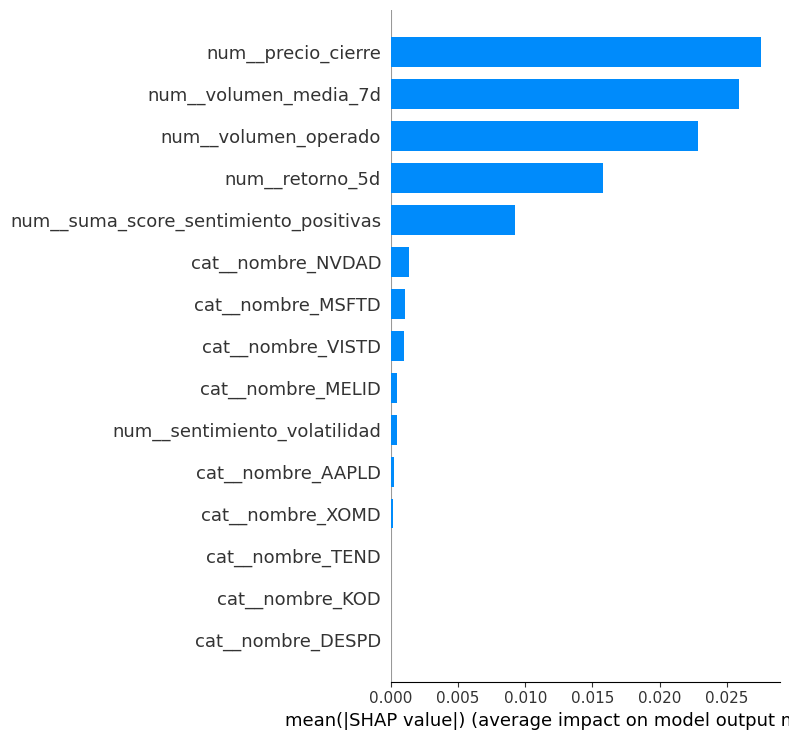

In [27]:
# Ejemplo para una empresa específica
empresa_ejemplo = "VISTD"
mask_ejemplo = (X_test['nombre'] == empresa_ejemplo)


# 1. Crea el explainer
explainer = shap.TreeExplainer(final_model)

# 2. Filtra los datos de la empresa de ejemplo y transforma
X_emp = preprocessor.transform(X_test[mask_ejemplo])

# 3. Calcula los valores SHAP
#    En problema binario, shap_values[1] son los valores para la clase “1” (p.ej. “sube”)
shap_vals = explainer.shap_values(X_emp)[1]
# 4. Asegúrate de que shap_vals sea 2D (n_samples × n_features)
if shap_vals.ndim == 1:
    shap_vals = shap_vals.reshape(1, -1)

# 5. Dibuja el bar plot

shap.summary_plot(
    shap_vals,
    X_emp,
    feature_names=preprocessor.get_feature_names_out(),
    plot_type="bar"
)


# 7. GUARDAR MODELO Y FEATURES

In [29]:
joblib.dump(study, 'modelo_lightgbm.pkl')
joblib.dump(scaler, 'scaler.pkl')
pd.Series(all_features).to_csv('features_seleccionadas.csv', index=False)

print("\n¡Modelo entrenado y guardado correctamente!")


¡Modelo entrenado y guardado correctamente!
